In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=e38a3d0bd483f53076bcc3952633e8b04fef1b164c63a339b6192cfcb9775f4a
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


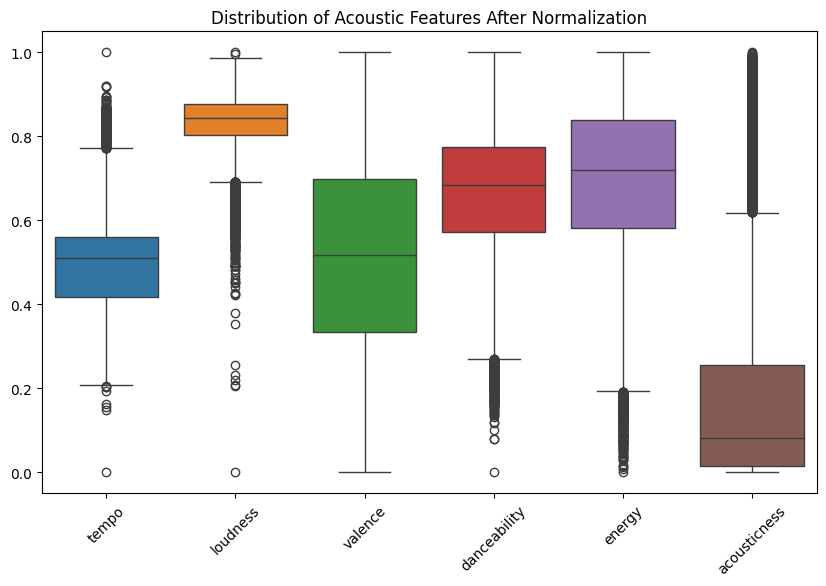

+--------------+----------+
|playlist_genre|prediction|
+--------------+----------+
|           pop|         0|
|           pop|         0|
|           pop|         0|
|           pop|         4|
|           pop|         0|
|           pop|         0|
|           pop|         4|
|           pop|         4|
|           pop|         4|
|           pop|         0|
|           pop|         0|
|           pop|         4|
|           pop|         0|
|           pop|         0|
|           pop|         4|
|           pop|         2|
|           pop|         4|
|           pop|         0|
|           pop|         1|
|           pop|         4|
+--------------+----------+
only showing top 20 rows



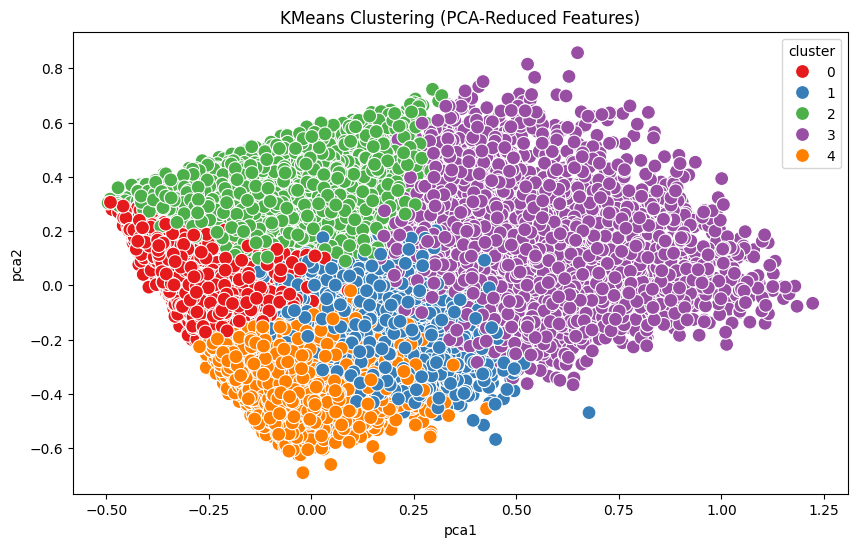

Silhouette Score for KMeans clustering: 0.19057615450196416
+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|     0|[{732, 104.520164...|
|     1|[{18031, 97.75417...|
|     2|[{1301, 103.17898...|
|     3|[{5865, 82.897415...|
|     4|[{300, 83.168655}...|
|     5|[{720, 101.09416}...|
|     6|[{377, 66.99671},...|
|     7|[{453, 84.996086}...|
|     8|[{5133, 85.022224...|
|     9|[{716, 92.469925}...|
|    10|[{646, 93.652855}...|
|    11|[{687, 98.254715}...|
|    12|[{583, 94.819214}...|
|    13|[{2276, 68.82491}...|
|    14|[{730, 101.5577},...|
|    15|[{1040, 66.985405...|
|    16|[{1123, 80.04519}...|
|    17|[{344, 103.90946}...|
|    18|[{716, 97.73894},...|
|    19|[{139, 92.47065},...|
+------+--------------------+
only showing top 20 rows



In [6]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.metrics import silhouette_score  # For silhouette evaluation

# Initialize Spark session
spark = SparkSession.builder.appName("MusicRecommendationSystem").getOrCreate()

# Load your dataset
data = pd.read_csv('/content/spotify dataset.csv')

# Preprocessing for KMeans Clustering (Genre Segmentation)
features = ['tempo', 'loudness', 'valence', 'danceability', 'energy', 'acousticness']

# Drop rows with missing values for these features
data_cleaned = data.dropna(subset=features)

# Normalize the features for clustering
scaler = MinMaxScaler()
data_cleaned[features] = scaler.fit_transform(data_cleaned[features])

# Visualize Preprocessing - Acoustic Features
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_cleaned[features])
plt.title("Distribution of Acoustic Features After Normalization")
plt.xticks(rotation=45)
plt.show()

# Convert to Spark DataFrame for KMeans Clustering
data_spark = spark.createDataFrame(data_cleaned)

# VectorAssembler to convert features into a vector for KMeans
vec_assembler = VectorAssembler(inputCols=features, outputCol="features")
data_spark_vec = vec_assembler.transform(data_spark)

# KMeans Clustering with k=5 (Example)
kmeans = KMeans(k=5, seed=1)
model_kmeans = kmeans.fit(data_spark_vec)
data_clustered = model_kmeans.transform(data_spark_vec)

# Assign clusters to genres (genre segmentation)
data_clustered.select("playlist_genre", "prediction").show()

# Dimensionality Reduction for Visualization (PCA)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_cleaned[features])
data_cleaned['pca1'] = data_pca[:, 0]
data_cleaned['pca2'] = data_pca[:, 1]
data_cleaned['cluster'] = data_clustered.toPandas()['prediction']

# Visualize KMeans Clustering Results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=data_cleaned, palette='Set1', s=100)
plt.title("KMeans Clustering (PCA-Reduced Features)")
plt.show()

# Compute Silhouette Score for KMeans Clustering
silhouette_avg = silhouette_score(data_cleaned[features], data_cleaned['cluster'])
print(f"Silhouette Score for KMeans clustering: {silhouette_avg}")

# ALS Recommendation System (Collaborative Filtering)
data['userId'] = pd.factorize(data['playlist_id'])[0]
data['trackId'] = pd.factorize(data['track_id'])[0]
data['rating'] = data['track_popularity']  # Use track popularity as proxy for rating

data_spark_als = spark.createDataFrame(data[['userId', 'trackId', 'rating']])

# ALS model for recommendations
als = ALS(maxIter=10, regParam=0.1, userCol="userId", itemCol="trackId", ratingCol="rating", coldStartStrategy="drop")
model_als = als.fit(data_spark_als)

# Recommend top 10 items for a user (using userId 1 as example)
user_recommendations = model_als.recommendForAllUsers(10)
user_recommendations.show()

# Function for Content-Based Recommendations (Cosine Similarity)
def get_song_recommendations(song_name, num_recommendations=10):
    song_data = data_cleaned[data_cleaned['track_name'].str.lower() == song_name.lower()]

    if song_data.empty:
        return "Song not found in the dataset."

    song_index = song_data.index[0]

    # Compute cosine similarity between the selected song and all other songs
    cosine_sim = cosine_similarity([data_cleaned.loc[song_index, features]], data_cleaned[features])

    # Get the top N most similar songs (excluding the song itself)
    similar_songs = cosine_sim.argsort()[0][-num_recommendations-1:-1][::-1]
    return data_cleaned.iloc[similar_songs][['track_name', 'track_artist', 'playlist_genre']]



In [7]:
# Example: Get recommendations based on user input
def recommend_songs():
    song_name = input("Enter the name of the song you want recommendations for: ")
    recommendations = get_song_recommendations(song_name)

    if isinstance(recommendations, str):
        print(recommendations)
    else:
        print(f"Recommended songs based on '{song_name}':")
        print(recommendations)

# Run the recommendation system to prompt user for song input
recommend_songs()

# Stop the Spark session after completion
spark.stop()

Enter the name of the song you want recommendations for: Shape of you
Recommended songs based on 'Shape of you':
               track_name                  track_artist playlist_genre
17488        Shape of You                    Ed Sheeran          latin
23867        Shape of You                    Ed Sheeran            r&b
23899        Shape of You                    Ed Sheeran            r&b
1218         Shape of You                    Ed Sheeran            pop
2317         Shape of You                    Ed Sheeran            pop
2838         Shape of You                    Ed Sheeran            pop
8533   Surrounded By Hoes                       50 Cent            rap
20506            Brujeria  El Gran Combo De Puerto Rico          latin
18539            Brujeria  El Gran Combo De Puerto Rico          latin
26451     Daddy's Got You                 Sunny Hawkins            r&b


In [11]:
# Import necessary libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans  # Use sklearn's KMeans
# from pyspark.ml.clustering import KMeans  # Commented out the PySpark KMeans

# ... (previous code) ...

# Apply KMeans clustering on the PCA-transformed data
kmeans = KMeans(n_clusters=5, random_state=1) # Changed k to n_clusters, added random_state
model_kmeans = kmeans.fit(pca_features)

# Calculate silhouette score for the PCA-reduced features
data_cleaned['cluster'] = model_kmeans.labels_  # Changed from transform to labels_
silhouette_avg = silhouette_score(pca_features, data_cleaned['cluster'])
print(f"Silhouette Score after PCA: {silhouette_avg}")

Silhouette Score after PCA: 0.34541910741382076
